In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

<center>
<h1> Import Picture of Maggie </h1>
</center>

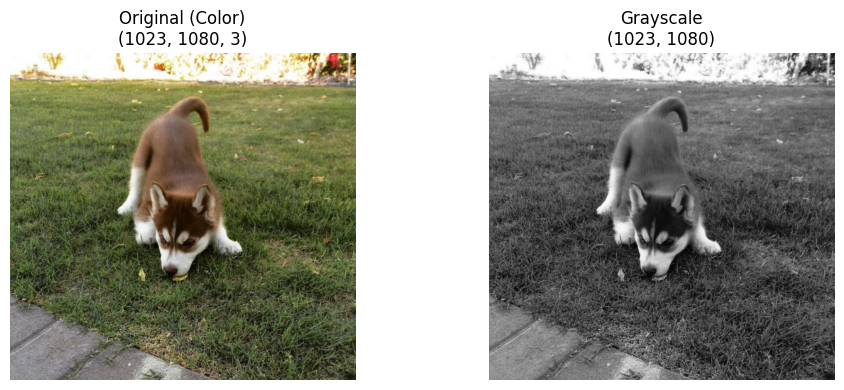

In [2]:
# Load the original image
maggie_color = imread('maggie.jpg')
maggie_gray = np.mean(maggie_color, axis=2)  # Convert to grayscale

# Show original (color) and grayscale images side by side, with their matrix sizes

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(maggie_color)
plt.title(f"Original (Color)\n{maggie_color.shape}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(maggie_gray, cmap='gray')
plt.title(f"Grayscale\n{maggie_gray.shape}")
plt.axis('off')

plt.tight_layout()
plt.show()

<center>
<h1> Truncated Singular Value Decomposition </h1>
</center>

The singular value decomposition (SVD) is a matrix factorization technique that takes any matrix $A\in\mathbb{R}^{m\times n}$ and factors it into $$A = USV^T,$$ where $U \in \mathbb{R}^{m\times m}$ and $V\in\mathbb{R}^{n\times n}$ are orthonormal, and $S\in\mathbb{R}^{m\times n}$ is a matrix whose diagonal elements are singular values $\sigma_{i}$ such that $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n \geq 0$.

Find the SVD of grayscale Maggie. Thus, we get that $$maggie = USV^T$$ where $U$ is of size $1023\times1023$, $S$ is of size $1023\times1023$, and $V$ is of size $1023\times1080$. $S$ is a diagonal matrix whose diagonal entries are the singular values.

In [3]:
maggie = maggie_gray
U, S, Vt = np.linalg.svd(maggie, full_matrices=False)
S = np.diag(S)

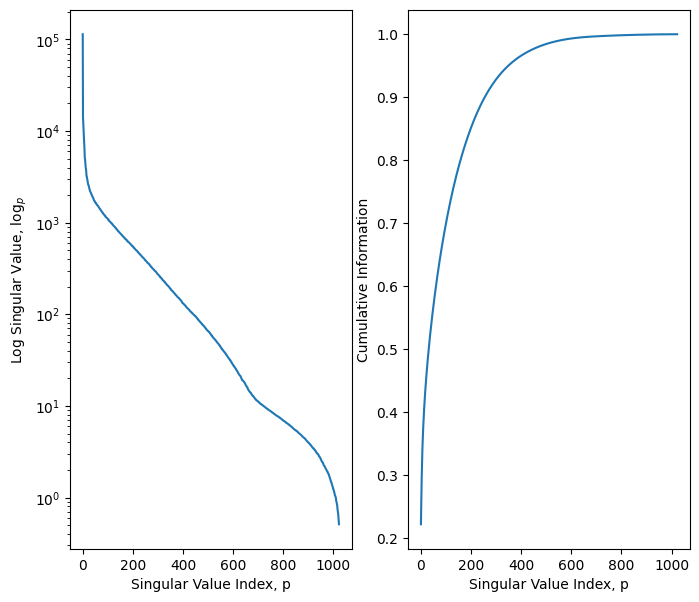

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 7))

axes[0].semilogy(np.diag(S))
axes[0].set_xlabel('Singular Value Index, p')
axes[0].set_ylabel(r'Log Singular Value, $\log_{p}$')  # Use raw string

axes[1].plot(np.cumsum(np.diag(S)) / np.sum(np.diag(S)))
axes[1].set_xlabel('Singular Value Index, p')
axes[1].set_ylabel('Cumulative Information')

plt.show()

Observe that in the figures above, the left plot shows a steep drop of the magnitude of the $p$ singular values of maggie for $p$ close to 0. This steep drop is what we're interested in as that is where most of the information is retained. The right plot shows how much information is retained given $p$ singular values. You can see that more than 90\% of the information is kept in the first 500 $p$ singular values which is less than half the amount of columns in maggie. 

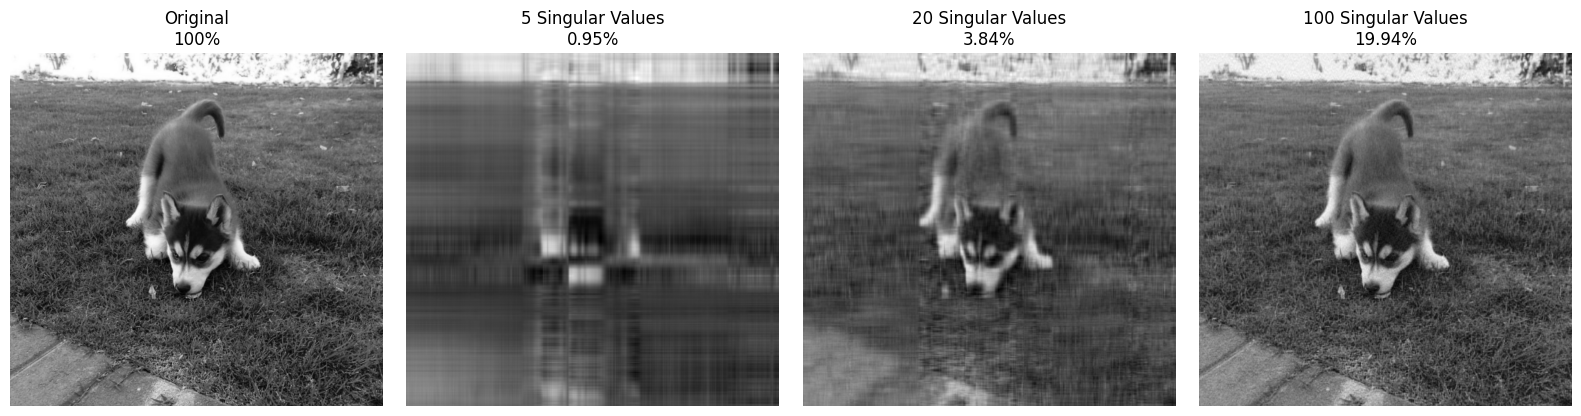

In [5]:
singular_values_list = [5, 20, 100]
n_images = len(singular_values_list) + 1  # +1 for the original

plt.figure(figsize=(16, 4))

# Storage for original grayscale image
original_storage = maggie.nbytes  # in bytes

# Show original image
plt.subplot(1, n_images, 1)
plt.imshow(maggie, cmap='gray')
plt.title("Original\n100%")
plt.axis('off')

# Show reconstructed images and their storage as percentage
for idx, j in enumerate(singular_values_list, start=2):
    maggie_reconstructed = U[:, :j] @ S[:j, :j] @ Vt[:j, :]
    # Storage for compressed SVD: U[:, :j], S[:j, :j], Vt[:j, :]
    storage = U[:, :j].nbytes + S[:j, :j].nbytes + Vt[:j, :].nbytes
    percent = (storage / original_storage) * 100
    plt.subplot(1, n_images, idx)
    plt.imshow(maggie_reconstructed, cmap='gray')
    plt.title(f"{j} Singular Values\n{percent:.2f}%")
    plt.axis('off')

plt.tight_layout()
plt.show()

In the figures above, you can already have a good visibility of Maggie with only using the first 100 singular values. Using $p = 100$ uses only about 20\% of the original picture's storage. Note that the image produced using TSVD has noticeably less quality than the original image. We can use Total Variation Denoising technique to enhance the quality of our TSVD image a bit. 

<center>
<h1> Total Variation Denoising </h1>
</center>

Total variation denoising (TVD) is a technique used to reduce noise in an image, especially effective for problems with discontinuous jumps. Let the denoised image be $\vec{y}$. The total variation of $\vec{y}$ is defined as:

$$
\text{TV}(\vec{y}) = \sum_{i=1}^{n-1} |y_{i+1} - y_i| = \|L\vec{y}\|_1
$$

where $L$ is the first-order difference matrix.

Let maggie = $X$. Consider our noisy image $X_p$, obtained using the truncation point $p = 100$. Suppose that $\vec{x}_p$ is the vector of the columns of $X_p$ concatenated. Our regularization problem becomes:

$$
F(\vec{x}_p) = \min \|\vec{y} - \vec{x}_p\|_2^2 + \lambda \|L\vec{x}_p\|_1 \tag{1}
$$

where $\lambda$ is a tuning parameter.

There is an approach called **majorization-minimization (MM)** to solve optimization problems that are too difficult to solve directly. Instead of minimizing equation (1), MM solves a sequence of optimization problems $G_k(\vec{x})$, for $k = 0, 1, 2, \ldots$. MM produces a sequence $x_k$ by minimizing $G_{k-1}(\vec{x})$. The idea is to choose $G_k(\vec{x})$ so that it is easy to solve but also approximates $F(\vec{x})$. The requirements are:

1. $G_k(\vec{x}) \geq F(\vec{x})$ for all $\vec{x}$ (i.e., $G_k(\vec{x})$ is a majorizer of $F(\vec{x})$).
2. $G_k(\vec{x}_k) = F(\vec{x}_k)$ at $\vec{x}_k$.
3. $G_k(\vec{x})$ are convex functions.

MM can be applied to TV by majorizing $\text{TV}(\vec{x})$ with a quadratic function of $\vec{x}$. Applying MM to equation (1) with $\lambda = 0.5$, the following results are obtained.

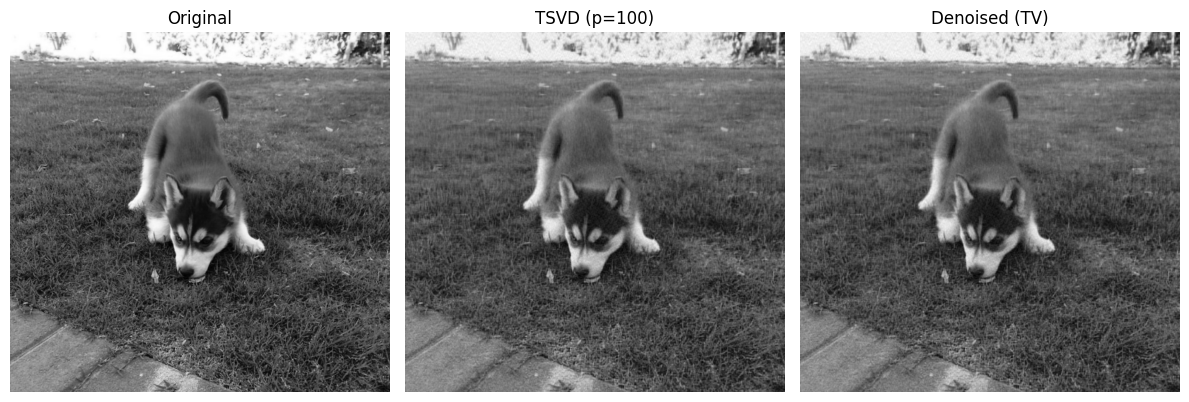

In [6]:
from skimage.restoration import denoise_tv_chambolle

# Reconstruct image with p = 100 singular values
p = 100
maggie_tsvd = U[:, :p] @ S[:p, :p] @ Vt[:p, :]

# Apply total variation denoising
maggie_denoised = denoise_tv_chambolle(maggie_tsvd, weight=0.1)

# Show original, TSVD, and denoised images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(maggie, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(maggie_tsvd, cmap='gray')
plt.title("TSVD (p=100)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(maggie_denoised, cmap='gray')
plt.title("Denoised (TV)")
plt.axis('off')

plt.tight_layout()
plt.show()

You can see that the denoised image is a bit sharper than the TSVD image. The figure above shows the comparison between the original image, TSVD image and the denoised (TV) image all while keeping the compressed image storage that the TSVD image has. 